In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv(".gitignore/combined_data_clean.csv")
df.columns = df.columns.str.strip()

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)


Columns: ['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HST', 'AST', 'B365H', 'B365A', 'BWH', 'BWA', 'PSH', 'PSA', 'WHH', 'WHA', 'MaxH', 'MaxA', 'AvgH', 'AvgA', 'AHh', 'B365CH', 'B365CA', 'BWCH', 'PSCH', 'PSCA', 'WHCH', 'MaxCH', 'MaxCA', 'AvgCH', 'AvgCA', 'AHCh', 'IWH', 'IWA', 'VCH', 'VCA']
Shape: (3863, 35)


In [3]:
betting_keywords = ['B365', 'BW', 'PS', 'WH', 'Max', 'Avg', 'VC', 'IW', 'AH']

df = df.drop(
    columns=[c for c in df.columns if any(k in c for k in betting_keywords)]
)

df.columns

Index(['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HST', 'AST'], dtype='object')

In [4]:
rename_map = {
    'FTHG': 'Full Time Home Goals',
    'FTAG': 'Full Time Away Goals',
    'FTR' : 'Full Time Result',
    'HTHG': 'Half Time Home Goals',
    'HTAG': 'Half Time Away Goals',
    'HST' : 'Home Shots on Target',
    'AST' : 'Away Shots on Target'
}
df = df.rename(columns=rename_map)
df.columns

Index(['Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',
       'Half Time Home Goals', 'Half Time Away Goals', 'Home Shots on Target',
       'Away Shots on Target'],
      dtype='object')

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df[
    [
        'Half Time Home Goals',
        'Half Time Away Goals',
        'Home Shots on Target',
        'Away Shots on Target'
    ]
]

y = df['Full Time Result']

encoder = LabelEncoder()
y = encoder.fit_transform(y)   # H / D / A → 0 / 1 / 2

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

knn_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=25, weights="distance"))
])

knn_model.fit(X_train, y_train)
pred = knn_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.6235446313065977


In [7]:
labels = np.unique(np.concatenate([y_test, pred]))

print("Labels in test/pred:", labels)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred, labels=labels))
print("\nReport:\n", classification_report(y_test, pred, labels=labels, digits=4))

Labels in test/pred: [0 1 2]

Confusion Matrix:
 [[154  31  36]
 [ 62  66  77]
 [ 29  56 262]]

Report:
               precision    recall  f1-score   support

           0     0.6286    0.6968    0.6609       221
           1     0.4314    0.3220    0.3687       205
           2     0.6987    0.7550    0.7258       347

    accuracy                         0.6235       773
   macro avg     0.5862    0.5913    0.5851       773
weighted avg     0.6077    0.6235    0.6125       773



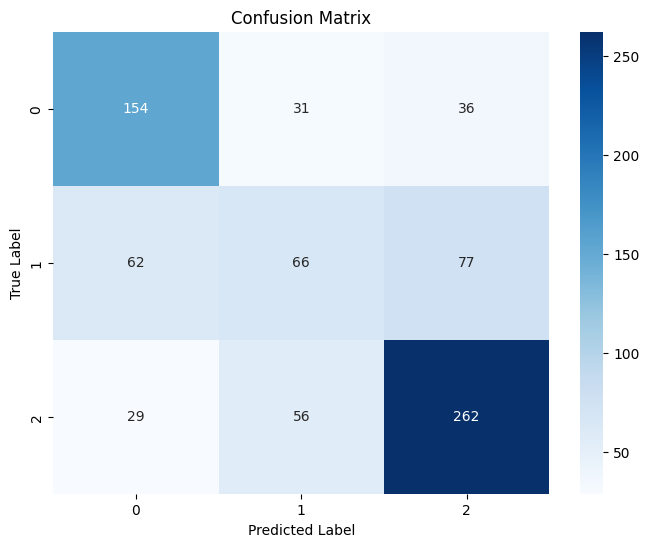

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [9]:
import joblib

# Define the filename for the saved model
model_filename = 'knn_model.pkl'

# Save the trained model to the file
joblib.dump(knn_model, model_filename)

print(f"Model successfully saved as '{model_filename}'")

Model successfully saved as 'knn_model.pkl'
